In [1]:
%matplotlib inline

import imp

try:
    imp.find_module('daft')
except ImportError:
    !pip install --user --upgrade daft

import daft

In [6]:
from PIL import Image, ImageChops

def trim(im, percent=36):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, (x.size[1]*percent)//100))

# EECS 545:  Machine Learning
## Lecture 13:  Bayesian Networks
* Instructor:  **Jacob Abernethy**
* Date:  March 9, 2016


*Lecture Exposition Credit: Benjamin Bray, Valliappa Chockalingam*

### Problem Setting

- Many problems in Machine Learning can be described with some number random variables.

- How do we model interactions between them?

### Joint Probability Table

- Given a set of random variables $\{x_1, ..., x_N\}$, the Joint Probability Table (JPT) $p(x_1, ..., x_N)$ lets you answer any probabilistic question that can be asked.

- Can we express a JPT any more concisely?

### Decomposing the JPT using the Chain Rule

By the chain rule of probability, we can also represent a joint distribution as follows:

$$\begin{align} 
p(\mathbf{x}_{1:N}) 
&= p(x_1) \cdot p(x_2 \mid x_1) \cdot p(x_3 \mid x_2, x_1) \hspace{0.1cm} \cdot \hspace{0.1cm} ... \cdot \hspace{0.1cm} p(x_N \mid \mathbf{x}_{1 : N - 1})\\
&= \prod \limits_{n = 1}^N p(x_n \mid \mathbf{x}_{1 : n - 1})
\end{align}$$

where $N$ is the number of variables and $\mathbf{x} = \{x_1, ..., x_N\}$.

### Problem?

Even with decomposition, ** The expression can become very large! **

- As $n$ gets large, $p(x_n \mid \mathbf{x}_{1 : n - 1})$ becomes more and more complicated to represent.
- Suppose all the variables can take $K$ values, then 
 - $p(x_1)$ has $O(K)$ parameters,
 - $p(x_2 \mid x_1)$ has $O(K^2)$ parameters, and so on giving,
 - $O(K^N)$ parameters in the model.

### A Solution: Use a graphical representation

Before explaining the solution, a brief review of graph theory and related terms is presented.

- Definition: A graph $G = (\nu, \epsilon)$ consists of 
 - A set of nodes or vertices, $V = \{\nu_1 ,···, \nu_n\}$, and,
 - A set of edges or links, $\epsilon = \{\epsilon_{1}, ..., \epsilon_{m}\} \subseteq V \times V$ where each $\epsilon_i$ is thus an ordered pair.

### Edge Related Terminology

- A node $u$ is said to be adjacent to another node $v$ if there is an edge from $u$ to $v$ or from $v$ to $u$. 
- If there is an edge *from* $u$ *to* $v$ then $u$ is often called the tail, while $v$ is called the head.

### Sparsity
 
 - A fully connected graph of $n$ nodes contains edges between every pair of nodes for a total of $n + (n - 1) + (n - 2) + ... + 1 = \frac{n(n - 1)}{2}$ edges.
 
 - A graph is said to be sparse if the number of edges $m \ll \frac{n(n - 1)}{2}$.
 - A graph is said to be dense if the number of edges $m \approx \frac{n(n - 1)}{2}$.

### Directedness

- A graph is said to be undirected if $\forall s, t, G(s, t) = 1 \leftrightarrow G(t, s) = 1$. 
- Otherwise it is said to be directed. 

### Representations: Adjacency Matrices

 - We often use an adjacency **matrix** to represent graphs: $G(t, s) = 1$ denotes $(s,t) \in \epsilon$.
     - Space Complexity of Adjacency Matrices: $O(n^2)$ where $n$ is the number of nodes.

### Representations: Adjacency List

- For sparse graphs, more compact representations exist such as Adjacency lists: Mapping of nodes to nodes they have an edge to (or from depending on the convention being used).
 - Space Complexity of Adjacency Lists: $O(m + n)$ where $m$ is the number of edges and $n$ is the number of nodes.

### Cyclicity
 - A graph is said to be cyclic if there exists a sequence of vertices that can be traversed using edges of the graph such that the sequence's first and last nodes are the same. 
 - If a graph is not cyclic, it is said to be acyclic.
  - Note: By definition, an acyclic graph is not reflexive (has no edges from nodes to themselves).

### The Graphical Representation 

- Let each node represent a random variable. 
- Link each variable to those it is conditionally dependent on.
 - *** Directed Acyclic Graph ***: Directed Edges, No Loops

### Review: Independence

- Random Variables $x$ and $y$ are said to be ***independent*** if $\boxed{p(x, y) = p(x) \cdot p(y)}$

- Knowing $x$ doesn't tell us any information about $y$ and vice versa.

### Review: Conditional Independence

- Random Variables $x$ and $y$ are said to be ***conditionally independent*** given $z$ if $\boxed{p(x, y \mid z) = p(x \mid z) \cdot p(y \mid z)}$

- Once $z$ is known, information about $x$ does not tell us any information about $y$ and vice versa.

In [4]:
%%capture
### Example 

pgm = daft.PGM([4, 4], origin=[0, 0])


# Nodes
pgm.add_node(daft.Node("a", r"$a$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("c", r"$c$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("a", "b", plot_params={'head_length' : 0.08})
pgm.add_edge("a", "c", plot_params={'head_length' : 0.08})
pgm.add_edge("b", "c", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("Example.png", dpi=1000)

AttributeError: 'dict' object has no attribute 'iteritems'

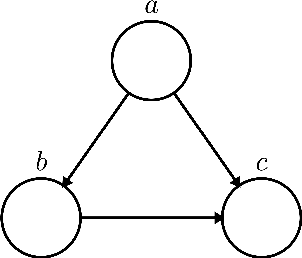

In [7]:
### An Example

trim(Image.open('Example.png'), 20)

# p(a, b, c) = p(c | a, b) x p(a, b) = p(c | a, b) x p(b | a) x p(a)

### Missing Links

- A *** Fully Connected Graph *** represents the fully general Joint Probability Table.
- In most domains, some variables will be independent or conditionally independent of others. So, some links will be missing.
 - The main advantage of the graphical representation.

### Building a Bayesian Network

- Specify the variables $\mathbf{x} = \{x_1, ..., x_N\}$.
- Identify what each variable depends on: 
 - $x_n$ depends on it's parent variables ${pa}_n \subseteq \{x_1, ..., x_{n - 1}\}$
 - Observation: Given ${pa}_n$, $x_n$ and $\{x_1, ..., x_{n - 1}\} \setminus {pa}_n$ are conditionally independent.

### Building a Bayesian Network 

- Add links to $x_n$ from its parent. 
 - These are often causal relations in the domain.
- Annotate $x_n$ with $p(x_n \mid pa_n)$.
 - $p(x_n \mid {pa}_n)$ is called a Conditional Probability Table (CPT).
- Finally, the Joint Probability Table (JPT) is then given by $p(\mathbf{x}) = \prod \limits_{n = 1}^N p(x_n \mid {pa}_n)$. This is sometimes refered to as the General Factorization for Bayesian Networks.

### Exercise

Construct a Bayesian Network to represent the Joint Probability Distribution: 
    $$\begin{align}p(x_1, x_2, x_3, x_4, x_5, x_6, x_7) = \hspace{0.2cm} &p(x_1) \cdot p(x_2) \cdot p(x_3) \cdot \\ &
p(x_4 \mid x_1, x_2, x_3) \cdot p(x_5 \mid x_1, x_3) \cdot \\ & p(x_6 \mid x_4) \cdot p(x_7 \mid x_4, x_5) \end{align}$$

In [ ]:
%%capture
# Answer to Exercise

pgm = daft.PGM([4, 4], origin=[0, 0])


# Nodes
pgm.add_node(daft.Node("x1", r"$x_1$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("x2", r"$x_2$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("x3", r"$x_3$", 2.7, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("x4", r"$x_4$", 1.6, 1.5, offset=(-20, 0)))
pgm.add_node(daft.Node("x5", r"$x_5$", 2.3, 1.5, offset=(20, 0)))
pgm.add_node(daft.Node("x6", r"$x_6$", 1.3, 0.5, offset=(-20, 0)))
pgm.add_node(daft.Node("x7", r"$x_7$", 2.7, 0.5, offset=(20, 0)))

# Add in the edges.
pgm.add_edge("x1", "x4", plot_params={'head_length' : 0.08})
pgm.add_edge("x1", "x5", plot_params={'head_length' : 0.08})
pgm.add_edge("x2", "x4", plot_params={'head_length' : 0.08})
pgm.add_edge("x3", "x4", plot_params={'head_length' : 0.08})
pgm.add_edge("x3", "x5", plot_params={'head_length' : 0.08})
pgm.add_edge("x4", "x6", plot_params={'head_length' : 0.08})
pgm.add_edge("x4", "x7", plot_params={'head_length' : 0.08})
pgm.add_edge("x5", "x7", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("Exercise.png", dpi=1000)

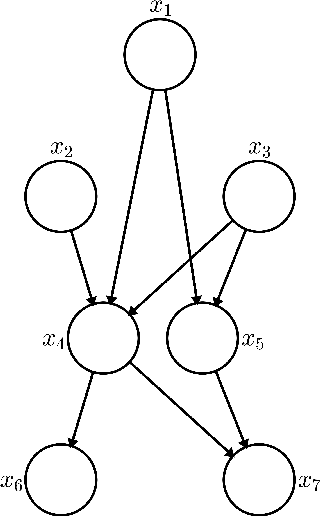

In [8]:
# Answer
trim(Image.open('Exercise.png'), 18)

### Bayesian Curve-Fitting

- Bayesian Regression problem.
- Random variables are the:
    - Vector of polynimal coefficients, $\mathbf{w}$, and the
    - Vector of observed data, $\mathbf{t} = (t_1, ..., t_N)^T$.
    
- Polynomial: $y(x, \mathbf{w}) = \sum \limits_{j = 0}^M w_j x^j$.
- Bayes Theorem Formulation: $p(\mathbf{t}, \mathbf{w}) = p(\mathbf{w}) \prod \limits_{n = 1}^N p(t_n \mid y(\mathbf{w}, x_n))$

### Plate Models

- We can use random variables $t_i$ and a weight vector $\mathbf{w}$.
- $\mathbf{w}$ is a parent of each of the $t_i$ variables.
- This is an ideal scenario for using plate models. 
 - ** Purpose of plate models:** Compactly represent multiple iterated nodes.

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("w", r"$w$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("t1", r"$t_1 . . . . . . . $", 1.3, 2.5, offset=(35, 0)))
pgm.add_node(daft.Node("t2", r"$t_N$", 2.7, 2.5, offset=(-20, 0)))

# Add in the edges.
pgm.add_edge("w", "t1", plot_params={'head_length' : 0.08})
pgm.add_edge("w", "t2", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("Poly_ellipsis.png", dpi=1000)

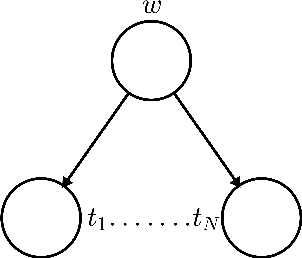

In [9]:
trim(Image.open('Poly_ellipsis.png'), 20)

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("w", r"$w$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("t_n", r"$t_n$", 3, 3.5, offset=(0, 20)))

pgm.add_plate(daft.Plate([2.5, 3, 1.1, 1], label=r"$n = 1, \ldots, N$",
    shift=-0.1))

# Add in the edges.
pgm.add_edge("w", "t_n", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("Poly_plate.png", dpi=1000, frameon=False)

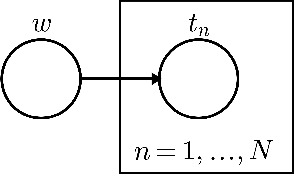

In [10]:
# Plate Example
trim(Image.open('Poly_plate.png'), 20)

$$\text{Model: } p(\mathbf{T}, \mathbf{w}) = p(\mathbf{w}) \prod \limits_{n = 1}^N p(t_n \mid \mathbf{w})$$

### Constant Parameters and Inputs?

- Open circles represent random variables. 
- Small filled circles represent constant parameters such as input, variance, and hyperparameters.

In [ ]:
%%capture
pgm = daft.PGM([5, 5], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("w", r"$w$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("t_n", r"$t_n$", 3, 3.5, offset=(0, 20)))

pgm.add_node(daft.Node("x_n", r"$x_n$", 3, 2.5, offset=(0, -20), fixed=True))
pgm.add_node(daft.Node("var", r"$\sigma^2$", 4, 3.5, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 2, 2.5, offset=(0, -20), fixed=True))

pgm.add_plate(daft.Plate([2.5, 2, 1.1, 2], label=r"$n = 1, \ldots, N$",
    shift=-0.1))

# Add in the edges.
pgm.add_edge("w", "t_n", plot_params={'head_length' : 0.08})
pgm.add_edge("alpha", "w", plot_params={'head_length' : 0.08})
pgm.add_edge("x_n", "t_n", plot_params={'head_length' : 0.08})
pgm.add_edge("var", "t_n", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("Poly_with_parameters.png", dpi=1000)

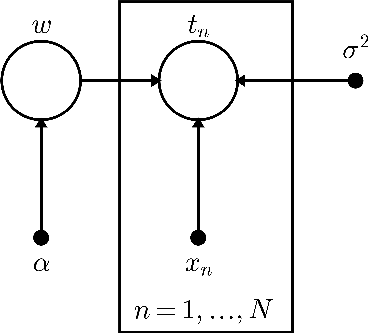

In [11]:
trim(Image.open('Poly_with_parameters.png'), 20)

$$\text{Model: } p(\mathbf{T}, \mathbf{w} \mid \mathbf{x}, \alpha, \sigma^2) = p(\mathbf{w} \mid \alpha) \prod \limits_{n = 1}^N p(t_n \mid \mathbf{w}, x_n, \sigma^2)$$

### Learning
Shaded Circles represent random variables with observed values.

In [ ]:
%%capture
pgm = daft.PGM([5, 5], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("w", r"$w$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("t_n", r"$t_n$", 3, 3.5, offset=(0, 20), observed=True))

pgm.add_node(daft.Node("x_n", r"$x_n$", 3, 2.5, offset=(0, -20), fixed=True))
pgm.add_node(daft.Node("var", r"$\sigma^2$", 4, 3.5, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 2, 2.5, offset=(0, -20), fixed=True))

pgm.add_plate(daft.Plate([2.5, 2, 1.1, 2], label=r"$n = 1, \ldots, N$",
    shift=-0.1))

# Add in the edges.
pgm.add_edge("w", "t_n", plot_params={'head_length' : 0.08})
pgm.add_edge("alpha", "w", plot_params={'head_length' : 0.08})
pgm.add_edge("x_n", "t_n", plot_params={'head_length' : 0.08})
pgm.add_edge("var", "t_n", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("Poly_after_observation.png", dpi=1000)

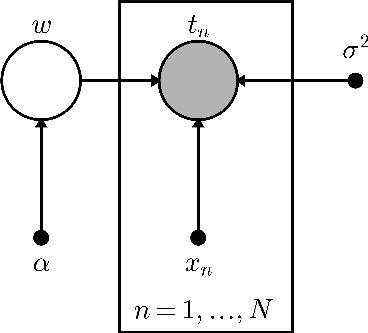

In [12]:
trim(Image.open('Poly_after_observation.png'), 20)

$$\text{Note: } p(\mathbf{w} \mid \mathbf{T}) \propto p(\mathbf{w}) \prod \limits_{n = 1}^N p(t_n \mid \mathbf{w})$$

### Prediction

- Add new variables to represent a query and the estimated target value.
- We are interested in the probability distribution $p(\hat{t})$ for a new input value $\hat{x}$ conditioned on the observed data. 

### Prediction

- The joint distribution can then be formulated as $$p(\hat{t}, \mathbf{T}, \mathbf{w} \mid \hat{x}, \mathbf{x}, \alpha, \sigma^2) =\\ \left[ \prod_{n = 1}^N p(t_n \mid x_n, \mathbf{w}, \sigma^2) \right] p(\mathbf{w} \mid \alpha) p(\hat{t} \mid \hat{x}, \mathbf{w}, \sigma^2)$$
- So the predictive distribution for $\hat{x}$ is given by $$p(\hat{t} \mid \hat{x}, \mathbf{x}, \mathbf{T}, \alpha, \sigma^2) \propto \int p(\hat{t}, \mathbf{T}, \mathbf{w} \mid \hat{x}, \mathbf{x}, \alpha, \sigma^2) \hspace{0.2cm} d\mathbf{w}$$

In [ ]:
%%capture
pgm = daft.PGM([6, 6], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("w", r"$w$", 2, 3.5, offset=(0, -20)))
pgm.add_node(daft.Node("t_n", r"$t_n$", 3, 3.5, offset=(20, 0), observed=True))
pgm.add_node(daft.Node("that", r"$\hat{t}$", 2, 4.5, offset=(0, 20)))

pgm.add_node(daft.Node("x_n", r"$x_n$", 3, 2.5, offset=(0, -20), fixed=True))
pgm.add_node(daft.Node("var", r"$\sigma^2$", 3, 4.5, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1, 3.5, fixed=True))
pgm.add_node(daft.Node("xhat", r"$\hat{x}$", 1, 4.5, fixed=True))


pgm.add_plate(daft.Plate([2.5, 2, 1.1, 2], label=r"$n = 1, \ldots, N$",
    shift=-0.1))

# Add in the edges.
pgm.add_edge("w", "t_n", plot_params={'head_length' : 0.08})
pgm.add_edge("alpha", "w", plot_params={'head_length' : 0.08})
pgm.add_edge("x_n", "t_n", plot_params={'head_length' : 0.08})
pgm.add_edge("var", "t_n", plot_params={'head_length' : 0.08})
pgm.add_edge("var", "that", plot_params={'head_length' : 0.08})
pgm.add_edge("xhat", "that", plot_params={'head_length' : 0.08})
pgm.add_edge("w", "that", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("Poly_prediction.png", dpi=1000)

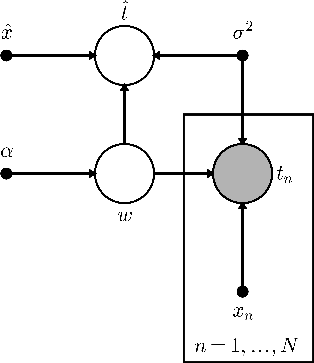

In [13]:
trim(Image.open('Poly_prediction.png'), 15)

### Directedness in Bayesian Networks and Sampling the Joint Distribution

- Question: How to sample the JPT $p(x_1, ..., x_k)$?

- In $p(x_n \mid {pa}_n)$, the variables in ${pa}_n$ come before $x_k$ in the ordering of variables, so we can sample in sequence.

### Example 

Given $p(a, b, c) = p(c \mid a, b) p(b \mid a) p(a)$

- Draw $a$ from the distribution $p(a)$.
- Given that value of $a$, draw $b$ from $p(b \mid a)$.
- Given $a$ and $b$, draw $c$ from $p(c \mid a, b)$.
- $(a, b, c)$ is then drawn from $p(a, b, c)$.

### Factorization: Joint Distribution of Discrete Variables  
#### Single Variable Case

- The probability distribution $p(\mathbf{x} \mid \mathbf{\mu})$ for a single discrete variable $\mathbf{x}$ that can take $K$ states is given by $p(\mathbf{x} \mid \mathbf{\mu}) = \prod \limits_{k = 1}^K \mu_k^{x_k}$.

- With the constraint that $\sum \limits_k \mu_k = 1$, only $K - 1$ free parameters are needed
 - Another way of thinking of this is with degrees of freedom.

### Factorization: Joint Distribution of Discrete Variables 
#### Two Variable Case

- Consider two discrete random variables $\mathbf{x}_1$ and $\mathbf{x}_2$, each of which has $K$ states.

- Let the parameter $\mu_{kl}$ denote the probability $p(\mathbf{x}_1 = k, \mathbf{x}_2 = l)$. 

- The joint distribution is then given by $p(\mathbf{x}_1, \mathbf{x}_2 \mid \mathbf{\mu}) = \prod \limits_{k = 1}^K \prod \limits_{l = 1}^K \mu_{kl}^{x_{1k}x_{2l}}$

- With $\sum_k \sum_l \mu_{kl} = 1$, the distribution is then governed by $K^2 - 1$ parameters.

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("x1", r"$x_1$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("x2", r"$x_2$", 3, 3.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("x1", "x2", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("2-gen.png", dpi=1000)

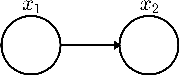

In [14]:
trim(Image.open('2-gen.png'), 15)

### Factorization: Joint Distribution of Discrete Variables 
#### General Case

Extending on the previous observations, we see that for a joint distribution over $N$ discrete variables, there are $K^N - 1$ states which grows ***exponentially*** in $N$.

### Factorization: Joint Distribution of Independent Discrete Variables - Two Variable Case

- Consider two random variables $\mathbf{x}_1$ and $\mathbf{x}_2$ that are independent and each of which can take $K$ states. 

- Each variable can then be described a separate multinomial distribution with $K - 1$ parameters for a total of $2(K - 1)$ parameters.

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("x1", r"$x_1$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("x2", r"$x_2$", 3, 3.5, offset=(0, 20)))

# Render and save.
pgm.render()
pgm.figure.savefig("2-ind.png", dpi=1000)

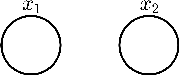

In [15]:
trim(Image.open('2-ind.png'), 15) 

### Factorization: Joint Distribution of Independent  Discrete Variables - General Case

- With $N$ independent discrete random variables, we can describe each with a multinomial distribution consisting of $K - 1$ parameters.

- Total number of parameters: $N(K - 1)$
 - Grows ***linearly*** in $N$.

### Observations 

- A Fully Connected Graph with $N$ nodes has $K^N - 1$ parameters. 

- A Fully Disconected Graph (one without any edges) had $N(K - 1)$ parameters.

- Graphs with intermediate levels of connectivity 
 - Allow for more general distributions than the fully factorized one, and, 
 - Require fewer parameters than the fully connected one.

### Conjugate Priors

- Dirichlet Priors can be added to the multinomial random variables. 
- Furthermore, a Diriclet prior can be shared by conditional distributions.

In [ ]:
%%capture
pgm = daft.PGM([6, 6], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("mu1", r"$\mathbf{\mu}_1$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("mu2", r"$\mathbf{\mu}_2$", 3, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("muN", r"$\mathbf{\mu}_N$", 4.5, 3.5, offset=(0, 20)))

pgm.add_node(daft.Node("x1", r"$\mathbf{x}_n$", 2, 2.5, offset=(0, -20)))
pgm.add_node(daft.Node("x2", r"$\mathbf{x}_2$", 3, 2.5, offset=(0, -20)))
pgm.add_node(daft.Node("ellipsis", r" . . . ", 3.7, 2.5, offset=(0, 0), plot_params={"ec" : "none"}))
pgm.add_node(daft.Node("ellipsis_end", r"", 3.7, 2.5, offset=(0, 0), plot_params={"ec" : "none"}))
pgm.add_node(daft.Node("xN", r"$\mathbf{x}_N$", 4.5, 2.5, offset=(0, -20)))


# Add in the edges.
pgm.add_edge("mu1", "x1", plot_params={'head_length':0.08})
pgm.add_edge("mu2", "x2", plot_params={'head_length':0.08})
pgm.add_edge("muN", "xN", plot_params={'head_length':0.08})
pgm.add_edge("x1", "x2", plot_params={'head_length':0.08})
pgm.add_edge("x2", "ellipsis", plot_params={'head_length':0.08})
pgm.add_edge("ellipsis_end", "xN", plot_params={'head_length':0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("Priors.png", dpi=1000)

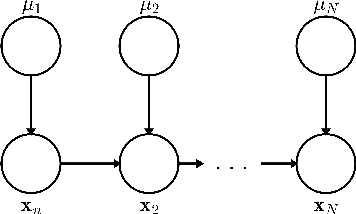

In [16]:
# Dirichlet Priors
trim(Image.open('Priors.png'), 15) 

$p(\{\mathbf{x}_n, \mathbf{\mu}_n\}) = p(\mathbf{x}_1 \mid \mathbf{\mu}_1) p(\mathbf{\mu}_1) \prod \limits_{n = 2}^N p(\mathbf{x}_n \mid \mathbf{x}_{n - 1}, \mathbf{\mu}_n) p(\mathbf{\mu}_n),$ 
where $p(\mathbf{\mu}_n) = Dir(\mathbf{\mu}_n \mid \mathbf{\alpha}_n)$

In [ ]:
%%capture
pgm = daft.PGM([6, 6], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("mu1", r"$\mathbf{\mu}_1$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("mu", r"$\mathbf{\mu}$", 3.75, 3.5, offset=(0, 20)))

pgm.add_node(daft.Node("x1", r"$\mathbf{x}_n$", 2, 2.5, offset=(0, -20)))
pgm.add_node(daft.Node("x2", r"$\mathbf{x}_2$", 3, 2.5, offset=(0, -20)))
pgm.add_node(daft.Node("ellipsis", r" . . . ", 3.7, 2.5, offset=(0, 0), plot_params={"ec" : "none"}))
pgm.add_node(daft.Node("ellipsis_end", r"", 3.7, 2.5, offset=(0, 0), plot_params={"ec" : "none"}))
pgm.add_node(daft.Node("xN", r"$\mathbf{x}_N$", 4.5, 2.5, offset=(0, -20)))


# Add in the edges.
pgm.add_edge("mu1", "x1", plot_params={'head_length':0.08})
pgm.add_edge("mu", "x2", plot_params={'head_length':0.08})
pgm.add_edge("mu", "xN", plot_params={'head_length':0.08})
pgm.add_edge("x1", "x2", plot_params={'head_length':0.08})
pgm.add_edge("x2", "ellipsis", plot_params={'head_length':0.08})
pgm.add_edge("ellipsis_end", "xN", plot_params={'head_length':0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("SharedPrior.png", dpi=1000)

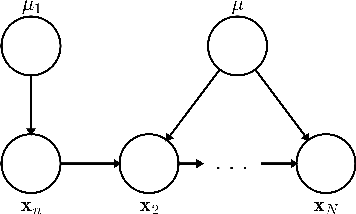

In [17]:
# Shared Prior
trim(Image.open('SharedPrior.png'), 15) 

$p(\{\mathbf{x}_n\}, \mathbf{\mu}_1, \mathbf{\mu}) = p(\mathbf{x}_1 \mid \mathbf{\mu}_1) p(\mathbf{\mu}_1) \prod \limits_{n = 2}^N p(\mathbf{x}_n \mid \mathbf{x}_{n - 1}, \mathbf{\mu}) p(\mathbf{\mu})$ 

### Parametrization Example 

- Consider $N$ binary random variables, each governed by a single parameter $\mu_i$ representing the probability $p(x_i = 1)$.
 - Total number of parameters: $N$

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("y", r"$w$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("x1", r"$x_1 . . . . . .$", 1.3, 2.5, offset=(32, 0)))
pgm.add_node(daft.Node("xN", r"$x_N$", 2.7, 2.5, offset=(-21, 0)))

# Add in the edges.
pgm.add_edge("y", "x1", plot_params={'head_length' : 0.08})
pgm.add_edge("y", "xN", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("ParametrizationEx-1.png", dpi=1000)

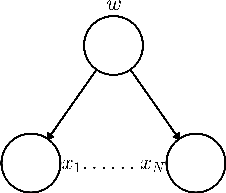

In [18]:
trim(Image.open("ParametrizationEx-1.png"), 15)

- However, note that the conditional distribution $p(y \mid x_1, ..., x_N)$ would require $2^N$ parameters.

### Parametrization Example 

One way to simplify the model is to use the ***logistic sigmoid function*** on a ***linear combination of the parent variables*** as follows $$p(y = 1 \mid x_1, ..., x_N) = \sigma \left( w_0 + \sum \limits_{i = 1}^N w_i x_i \right) = \sigma(\mathbf{W}^T\mathbf{x})$$

where $\sigma(t) = (1 + \exp(-t))^{-1}$ is the logistic sigmoid, $\mathbf{x} = (1, x_1, ..., x_N)^T$ is an $(N + 1)$-dimensional vector and $\mathbf{w} = (w_0, ..., w_N)^T$ is a vector of $N + 1$ parameters! 
***Note: Linear in the number of variables as opposed to exponential! ***

### Data Complexity 

- How many parameters specify the distribution of $N$ discrete (say, binary) variables?
 - If the graph is disconnected (no edges at all), $O(N)$.
 - If the graph is fully connected, $O(2^N)$.
 - Partial structure gives intermediate complexity.
- For $N$ Gaussian variables? (Verify these.)
 - If graph is disconnected (again, no edges at all), $O(N)$.
 - If graph is fully connected, $O(N^2)$.

### Conditional Independence Revisited

- Recall, Random Variables $x$ and $y$ are said to be ***conditionally independent*** given $z$ if $\boxed{p(x, y \mid z) = p(x \mid z) \cdot p(y \mid z)}$


- Notation: 
 - $a \!\perp\!\!\!\perp b \mid c$, or,
 - $a \perp b \mid c$.
 
 
- How to infer such structure from a graph?

In [ ]:
%%capture
### Example 

pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("c", r"$c$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("a", r"$a$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("c", "a", plot_params={'head_length' : 0.08})
pgm.add_edge("c", "b", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("CondIndExample1.png", dpi=1000)

In [ ]:
# Example 1
# Question: Are a and b conditionally independent 
#           in the given scenario?
trim(Image.open('CondIndExample1.png'), 20)

### Answer 

- No, $a$ and $b$ are not conditionally independent given the empty set.

- Note: $c$ is ***not*** given! In particular, it is not shaded. 

- Explanation: 
 - The joint distribution is given by $p(a, b, c) = p(a \mid c)p(b \mid c) p(c)$
 - The marginal distribution is given by $p(a, b) = \sum_c p(a \mid c) p(b \mid c) p(c)$ which in general does not factorize into $p(a) p(b)$. 
 
 - Therefore, $a \not\!\perp\!\!\!\perp b \mid \emptyset$.


### A subtle point
- Following the notation of the book, expressions such as $P(E \mid \emptyset)$ and $a \not\!\perp\!\!\!\perp b \mid \emptyset$ are used here.
- However, technically, expressions such as $p(E \mid \emptyset)$ are undefined. 
- The intuition is to think of the empty as denoteing "given no information" or rather the universal set in fact.
 - In this scenario, the conditional independence of $a$ and $b$ is really equivalent to $a$ and $b$ being independent. This is the reason we are looking for whether the marginal distribution $p(a, b)$ is equal to $p(a)p(b)$.

In [ ]:
%%capture
### Example 

pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("c", r"$c$", 2, 3.5, offset=(0, 20), 
                       observed=True))
pgm.add_node(daft.Node("a", r"$a$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("c", "a", plot_params={'head_length' : 0.08})
pgm.add_edge("c", "b", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("CondIndExample1-observed.png", dpi=1000)

In [ ]:
# Example 1 after Observation
# Question: Are a and b conditionally independent 
#           in the given scenario?
trim(Image.open('CondIndExample1-observed.png'), 20)

### Answer 

- Yes, $a$ and $b$ are conditionally independent given the $c$.

- Given $c$, $p(a, b \mid c) = \frac{p(a, b, c)}{p(c)} = p(a \mid c) p(b \mid c)$ (recall previous slide about the joint distribution.)

- Thus, we have $a \!\perp\!\!\!\perp b \mid c.$

### Tail-to-Tail 

- Note that there is an ***undirected*** path from node $a$ to node $b$ via $c$. 

- Node $c$ is tail-to-tail with respect to this path (node c is at the tail of both of the edges).

- Thus, for a tail-to-tail connections, 
 - $a$ and $b$ are dependent, but, 
 - the conditioned node, $c$, *** blocks *** the path from a to b and causes a and b to become independent.

In [ ]:
%%capture
### Example 

pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("c", r"$c$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("a", r"$a$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("a", "c", plot_params={'head_length' : 0.08})
pgm.add_edge("c", "b", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("CondIndExample2.png", dpi=1000)

In [ ]:
# Example 2
# Question: Are a and b conditionally independent 
#           in the given scenario?
trim(Image.open('CondIndExample2.png'), 20) 

### Answer 

- No, $a$ and $b$ are not conditionally independent given the empty set.

- Note: Again, $c$ is ***not*** given! In particular, it is not shaded. 

- Explanation: 
 - The joint distribution is given by $p(a, b, c) = p(a)p(c \mid a) p(b \mid c)$
 - $p(a, b)$ is given by $p(a) \sum_c p(c \mid a) p(b \mid c) = p(a)p(b \mid a) $ which in general does not factorize into $p(a) p(b)$. 
 
 - Therefore, $a \not\!\perp\!\!\!\perp b \mid \emptyset$.

In [ ]:
%%capture
### Example 

pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("c", r"$c$", 2, 3.5, offset=(0, 20), 
                       observed = True))
pgm.add_node(daft.Node("a", r"$a$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("a", "c", plot_params={'head_length' : 0.08})
pgm.add_edge("c", "b", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("CondIndExample2-observed.png", dpi=1000)

In [ ]:
# Example 2 after observation
# Question: Are a and b conditionally independent 
#           in the given scenario?
trim(Image.open('CondIndExample2-observed.png'), 20) 

### Answer 

- Yes, $a$ and $b$ are conditionally independent given the $c$.

- Given $c$, $p(a, b \mid c) = \frac{p(a, b, c)}{p(c)} = \frac{p(a)p(c \mid a) p(b \mid c)}{p(c)} = p(a \mid c) p(b \mid c) \\$ 

- Thus, we have $a \!\perp\!\!\!\perp b \mid c.$

### Head-to-Tail 

- Note that there is an ***undirected*** path from node $a$ to node $b$ via $c$. 

- Node $c$ is head-to-tail with respect to this path (node c is at the head of the edge from $a$ and at the tail of the edge to $b$.)

- Thus, for a head-to-tail connection, 
 - $a$ and $b$ are dependent, but, 
 - the conditioned node, $c$, *** blocks *** the path from a to b and causes a and b to become independent.

In [ ]:
%%capture
### Example 

pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("c", r"$c$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("a", r"$a$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("a", "c", plot_params={'head_length' : 0.08})
pgm.add_edge("b", "c", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("CondIndExample3.png", dpi=1000)

In [ ]:
# Example 3 
# Question: Are a and b conditionally independent 
#           in the given scenario?
trim(Image.open('CondIndExample3.png'), 20) 

### Answer 

- Yes, $a$ and $b$ are conditionally independent given the empty set! 

- Explanation: 
 - The joint distribution is given by $p(a, b, c) = p(a)p(b)p(c \mid a, b)$.
 - When none of the variables are observed, marginalizing both sides leads to $p(a, b) = p(a)P(b)$.
 - Therefore, $a$ and $b$ are independent with no variables observed, in contrast to the previous two examples, $a \!\perp\!\!\!\perp b \mid \emptyset$

In [ ]:
%%capture
### Example 

pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("c", r"$c$", 2, 3.5, offset=(0, 20), 
                       observed=True))
pgm.add_node(daft.Node("a", r"$a$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("a", "c", plot_params={'head_length' : 0.08})
pgm.add_edge("b", "c", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("CondIndExample3-observed.png", dpi=1000)

In [ ]:
# Example 3 after observation
# Question: Are a and b conditionally independent 
#           in the given scenario?
trim(Image.open('CondIndExample3-observed.png'), 20) 

### Answer 

- No, $a$ and $b$ are not conditionally independent given the $c$.

- Given $c$, $p(a, b \mid c) \begin{align} = \frac{p(a, b, c)}{p(c)} = \frac{p(a)p(b) p(c \mid a, b)}{p(c)}\end{align}$.
 - This in general does not factorize to $p(a \mid c) p(b \mid c)$.

- Thus, we have $a \not\!\perp\!\!\!\perp b \mid c.$

### Head-to-Head 

- Note that there is an ***undirected*** path from node $a$ to node $b$ via $c$. 

- Node $c$ is head-to-head with respect to this path (node c is at the head of both the edges.)

- Thus, for a head-to-head connection, 
 - $a$ and $b$ are ***independent***, but, 
 - the conditioned node, $c$, *** unblocks *** the path from a to b and causes a and b to become ***dependent***.

### Battery, Fuel and Gauge Example

- Consider three random variables: 
    - $B$ which represents the state of the battery that is either charged, $B = 1$, or flat, $B = 0$,
    - $F$ which represents the state of the fuel tank that is either full, $F = 1$, or empty, $F = 0$, and,
    - $G$ which represents the state of an electical fuel gauge which indicates either full, $G = 1$ or empty, $G = 0$. 
    
- $B$ and $F$ are independent with priors: 
 - $p(B = 1) = 0.9$
 - $p(F = 1) = 0.9$

### Further Setup of the example

Given the state of the fuel tank and the battery, the fuel gauge reads full with probabilities: 
 - $p(G = 1 \mid B = 1, F = 1) = 0.8$
 - $p(G = 1 \mid B = 1, F = 0) = 0.2$
 - $p(G = 1 \mid B = 0, F = 1) = 0.2$
 - $p(G = 1 \mid B = 0, F = 0) = 0.1$

### Analysis 

- Without any observations, the prior of the fuel tank being empty is given by $1 - P(F = 1) = 1 - 0.9 = 0.1$.

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("G", r"$G$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("B", r"$B$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("F", r"$F$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("B", "G", plot_params={'head_length' : 0.08})
pgm.add_edge("F", "G", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("OutOfFuel1.png", dpi=1000)

In [ ]:
trim(Image.open("OutOfFuel1.png"), 15)

### Analysis
- Now, suppose we observe $G = 0$. 
 - $p(G = 0) = \\
 \sum \limits_{B \in \{0, 1\}} \sum \limits_{F \in \{0, 1\}} 
 p(G = 0 \mid B, F) p(B) p(F) = 0.315$
 
(Try to verify this.)

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("G", r"$G$", 2, 3.5, offset=(0, 20), observed=True))
pgm.add_node(daft.Node("B", r"$B$", 1.3, 2.5, offset=(0, 20)))
pgm.add_node(daft.Node("F", r"$F$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("B", "G", plot_params={'head_length' : 0.08})
pgm.add_edge("F", "G", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("OutOfFuel2.png", dpi=1000)

In [ ]:
trim(Image.open("OutOfFuel2.png"), 15)

### Analysis

- Now, we also have $p(G = 0 \mid F = 0) = \\ \sum \limits_{B \in \{0, 1\}} p(G = 0 \mid B, F = 0) p(B) = 0.81.$ 

- So, by Bayes Rule, $p(F = 0 \mid G = 0) = \frac{p(G = 0 \mid F = 0) p(F = 0)}{p(G = 0)} \\ \approx 0.257 > p(F = 0) = 0.1$

- Thus, observing the gauge reads empty makes it more likely that the tank is empty.

### Analysis

- Now, suppose we also observe that the battery is flat, $B = 0$.

- The posterior that the fuel tank is empty given this new observation is then $p(F = 0 \mid G = 0, B = 0) = \frac{p(G = 0 \mid B = 0, F = 0) p(F = 0)}{\sum_{F \in \{0, 1\}} p(G = 0 \mid B = 0, F) p(F)} \approx 0.111$

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("G", r"$G$", 2, 3.5, offset=(0, 20), observed=True))
pgm.add_node(daft.Node("B", r"$B$", 1.3, 2.5, offset=(0, 20), observed=True))
pgm.add_node(daft.Node("F", r"$F$", 2.7, 2.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("B", "G", plot_params={'head_length' : 0.08})
pgm.add_edge("F", "G", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("OutOfFuel3.png", dpi=1000)

In [ ]:
trim(Image.open("OutOfFuel3.png"), 20)

### "Explanining Away"

- The probability that the tank is empty has now decreased from 0.257 to 0.111 as a result of oberving the state of the battery!

- On the other hand (try to verify this as well), on observing that the battery is full, the posterior, $p(F = 0 \mid G = 0, B = 1)$ increases to 0.308.

- Observing B = 0 (battery is flat) explains away F = 0 (the fuel tank is empty). Therefore, B and F become dependent on each other as a result of observing G = 0.

### D-Separation

- Method to determine whether any pair of sets $A$ and $B$ of variables are conditionally independent, given knowledge of values of variables in $C$.

- Graphical model contains everything needed to infer conditional independence.

### D-Separation

- Let $A$, $B$, and $C$ be ***mutually exclusive*** subsets of nodes in a Bayesian Network.
- A path from $A$ to $B$ is blocked (when $C$ is observed) if it contains a node such that either: 
 - The arrows on the path meet head-to-tail or tail-to-tail at the node, and the node is in set $C$, or
 - The arrows meet head-to-head at the node, and neither the node, nor *** any *** of its descendants, are in set $C$.

### D-Separation

- If all paths from $A$ to $B$ are blocked,
 - $A$ is said to be d-separated from $B$ by $C$, and,
 - The joint distribution over all variables in the graph satsifies $A \perp B \mid C$.

In [ ]:
%%capture
pgm = daft.PGM([5, 5], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("a", r"$a$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 3.5, 2.5, offset=(-20, 0)))
pgm.add_node(daft.Node("c", r"$c$", 2.5, 1.5, offset=(-20, 0), observed=True))
pgm.add_node(daft.Node("e", r"$e$", 2.5, 2.5, offset=(-20, 0)))
pgm.add_node(daft.Node("f", r"$f$", 3, 3.5, offset=(0, 20)))

# Add in the edges.
pgm.add_edge("a", "e", plot_params={'head_length' : 0.08})
pgm.add_edge("f", "e", plot_params={'head_length' : 0.08})
pgm.add_edge("e", "c", plot_params={'head_length' : 0.08})
pgm.add_edge("f", "b", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("DSepExample-1.png", dpi=1000)

In [ ]:
# Example
# Question: Given c, are a and b conditionally independent?
trim(Image.open("DSepExample-1.png"), 20)

### Answer 

- The path from $a$ to $b$ is not blocked by node $f$ as $f$ is a tail-to-tail node and it is not observed.
- Furthermore, while $e$ is a head-to-head node with respect to the undirected path from $a$ to $b$, the path is not blocked by $e$ since $e$ has a descendant $c$ in the conditioning set.

- Therefore, $a \not \perp b \mid c$.

In [ ]:
%%capture
pgm = daft.PGM([5, 5], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("a", r"$a$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("b", r"$b$", 3.5, 2.5, offset=(-20, 0)))
pgm.add_node(daft.Node("c", r"$c$", 2.5, 1.5, offset=(-20, 0)))
pgm.add_node(daft.Node("e", r"$e$", 2.5, 2.5, offset=(-20, 0)))
pgm.add_node(daft.Node("f", r"$f$", 3, 3.5, offset=(0, 20), observed=True))

# Add in the edges.
pgm.add_edge("a", "e", plot_params={'head_length' : 0.08})
pgm.add_edge("f", "e", plot_params={'head_length' : 0.08})
pgm.add_edge("e", "c", plot_params={'head_length' : 0.08})
pgm.add_edge("f", "b", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("DSepExample-2.png", dpi=1000)

In [ ]:
# Example
# Question: Given f, are a and b conditionally independent?
trim(Image.open("DSepExample-2.png"), 20)

### Answer 

- The path from $a$ to $b$ is blocked by node $f$ as $f$ is a tail-to-tail node and it is observed.

- Therefore, $a \perp b \mid f$.

- Furthermore, the undirected path from $a$ to $b$ is blocked by $e$ because 
 - $e$ is a head-to-head node, and,
 - Neither it nor any of its descendants (in this case only $c$) are in the conditioning set. 

- Thus, clearly, we again then have that $a \perp b \mid f$ 

### Parameters in D-Separation?

- Recall that parameter nodes are the small filled nodes.

- In D-Sepration, they behave in a similar manner to observed nodes.
- There are no marginal distributions associated with such nodes, and therefore, parameter nodes never have parents and all paths through these will always be 
 - Tail-to-tail, and hence,
 - Blocked.
- Hence, parameters play no role in D-Separation.

### D-separation: I.I.D. Data

In [ ]:
%%capture
pgm = daft.PGM([4, 4], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("mu", r"$\mu$", 2, 3.5, offset=(0, 20)))
pgm.add_node(daft.Node("x1", r"$x_1 . . . . . .$", 1.3, 2.5, offset=(32, 0), observed=True))
pgm.add_node(daft.Node("xN", r"$x_N$", 2.7, 2.5, offset=(-21, 0), observed=True))

# Add in the edges.
pgm.add_edge("mu", "x1", plot_params={'head_length' : 0.08})
pgm.add_edge("mu", "xN", plot_params={'head_length' : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("IID.png", dpi=1000)

In [ ]:
trim(Image.open("IID.png"), 15)

- Let us condition on $\mu$ and consider the joint distribution of the observations, $\mathcal{D} = \{x_1 , · · · , x_N\}$. 
- There is a unique path from any $x_i$ to any other $x_{j \neq i}$.
 - This path is tail-to-tail w.r.t. $\mu$.
 - Every such path is blocked and the observations are independent given $\mu$: $p(\mathcal{D} \mid \mu) = \prod \limits_{n = 1}^N p(x_n \mid \mu)$


### D-Separation: I.I.D. Data

- Now, integrating over $\mu$ (taking $\mu$ to be unobserved), the observations ($\mathcal{D}$) are in general no longer independent: 
 $$p(\mathcal{D}) = \int \limits_{-\infty}^{\infty} p(\mathcal{D} \mid \mu) p(\mu) d\mu \neq \prod \limits_{n = 1}^N p(x_n)$$

### Markov Blanket

- Consider a joint distribution $p(\mathbf{x}_1, ..., \mathbf{x}_N)$ represented by a directed graph having $N$ nodes, and the conditional distribution of a node $\mathbf{x}_i$ conditioned on all of the remaining variables $\mathbf{x}_{j \neq i}$.

- Using factorization, we can express the conditional distribution in the form $$p(\mathbf{x}_i \mid \mathbf{x}_{j \neq i}) = \frac{p(\mathbf{x}_1, ..., \mathbf{x}_N)}{\int p(\mathbf{x}_1, ..., \mathbf{x}_N) d\mathbf{x}_i} = \frac{\prod_k p(\mathbf{x}_k \mid {pa}_k)}{\int \prod_k p(\mathbf{x}_k \mid {pa}_k) d\mathbf{x}_i}$$

### Markov Blanket

- Any factor $p(\mathbf{x}_k \mid {pa}_k)$ that does not have a function dependence on $\mathbf{x}_i$ can be taken outside the intergral over $\mathbf{x}_i$, and will cancel with the numerator.

- Remaining factors will then be: 
 - The conditional distribution $p(\mathbf{x}_i \mid {pa}_i)$ for node $\mathbf{x}_i$ itself, and,
 - Conditional distributions for nodes $\mathbf{x}_k$ such that $\mathbf{x}_i \in {pa}_k$

### Markov Blanket

- The conditional $p(\mathbf{x}_i \mid {pa}_i)$ depends on the parents of $\mathbf{x}_i$.
- The conditionals $p(\mathbf{x}_k \mid {pa}_k)$ depend on the children of $\mathbf{x}_i$ as well as the co-parents.

- Definition: The set of nodes comprising the parents, the children and the co-parents is called the
Markov blanket
 - The minimal set of nodes that isolates $\mathbf{x}_i$ from the rest of the graph. 

In [ ]:
%%capture
# Instantiate the PGM.
pgm = daft.PGM([6, 6], origin=[-1, -1])

pgm.add_node(daft.Node("x2", "", 1, 0, observed=True))
pgm.add_node(daft.Node("x1", "", 0, 1, observed=True))
pgm.add_node(daft.Node("x3", "", 1, 2, observed=True))
pgm.add_node(daft.Node("xi", r"$\mathbf{x}_i$", 2, 1, offset=(0, 20)))
pgm.add_node(daft.Node("x4", "", 3, 0, observed=True))
pgm.add_node(daft.Node("x6", "", 4, 1, observed=True))
pgm.add_node(daft.Node("x5", "", 3, 2, observed=True))

pgm.add_edge("x1", "x2", plot_params={"head_length" : 0.08})
pgm.add_edge("xi", "x2", plot_params={"head_length" : 0.08})
pgm.add_edge("x3", "xi", plot_params={"head_length" : 0.08})
pgm.add_edge("x5", "xi", plot_params={"head_length" : 0.08})
pgm.add_edge("xi", "x4", plot_params={"head_length" : 0.08})
pgm.add_edge("x6", "x4", plot_params={"head_length" : 0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("MarkovBlanket.png", dpi=1000)

In [ ]:
trim(Image.open("MarkovBlanket.png"), 10)

### Example Application of Bayesian Networks
#### Medical Diagnosis

- Findings: $\mathbf{f}$
- Diseases: $\mathbf{d}$

In [ ]:
%%capture
pgm = daft.PGM([6, 6], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("d1", r"$d_1$", 2, 3.5, offset=(0, 25)))
pgm.add_node(daft.Node("di", r"", 3, 3.5))
pgm.add_node(daft.Node("dn", r"$d_n$", 4, 3.5, offset=(0, 25)))

pgm.add_node(daft.Node("f1", r"$f_1$", 1, 2.5, offset=(0, -25)))
pgm.add_node(daft.Node("fi-1", r"", 2, 2.5))
pgm.add_node(daft.Node("fi", r"", 3, 2.5))
pgm.add_node(daft.Node("fi+1", r"", 4, 2.5))
pgm.add_node(daft.Node("fm", r"$f_m$", 5, 2.5, offset=(0, -25)))


# Add in the edges.
pgm.add_edge("d1", "f1", plot_params={'head_length':0.08})
pgm.add_edge("d1", "fi-1", plot_params={'head_length':0.08})
pgm.add_edge("d1", "fi", plot_params={'head_length':0.08})
pgm.add_edge("d1", "fi+1", plot_params={'head_length':0.08})
pgm.add_edge("d1", "fm", plot_params={'head_length':0.08})

pgm.add_edge("di", "f1", plot_params={'head_length':0.08})
pgm.add_edge("di", "fi-1", plot_params={'head_length':0.08})
pgm.add_edge("di", "fi", plot_params={'head_length':0.08})
pgm.add_edge("di", "fi+1", plot_params={'head_length':0.08})
pgm.add_edge("di", "fm", plot_params={'head_length':0.08})

pgm.add_edge("dn", "f1", plot_params={'head_length':0.08})
pgm.add_edge("dn", "fi-1", plot_params={'head_length':0.08})
pgm.add_edge("dn", "fi", plot_params={'head_length':0.08})
pgm.add_edge("dn", "fi+1", plot_params={'head_length':0.08})
pgm.add_edge("dn", "fm", plot_params={'head_length':0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("DiagnosisExample.png", dpi=1000)

In [ ]:
trim(Image.open("DiagnosisExample.png"), 15)

### Medical Diagnosis

- Joint distribution factors as: $p(\mathbf{f}, \mathbf{d}) = \prod_j p(d_j) \prod_i p(f_i \mid \mathbf{d})$
- Model assumes: $d_i \perp d_j$ and $f_i \perp f_j \mid \mathbf{d}$

### Medical Diagnosis

- Problem: Common findings can be caused by many diseases.
 - Too many parameters needed to specify the Conditional Probability Distribution of $p(f_i \mid \mathbf{d})$.
 
- Parametrization: Use Noisy-OR
 - $p(f_i = 0 \mid \mathbf{d}) = (1 - q_{i0}) \prod \limits_{j \in {pa}_i} (1 - q_{ij})^d_j$ where $q_{ij}$ represents the "independent failure probability" of witnessing disease $d_j$ without finding $f_i$.

### Example Application of Bayesian Networks
#### Hidden Markov Model 

- Frequently used for speech recognition and part-of-speech tagging.

In [ ]:
%%capture
pgm = daft.PGM([7, 7], origin=[0, 0])

# Nodes
pgm.add_node(daft.Node("Y1", r"$Y_1$", 1, 3.5, offset=(0, 25)))
pgm.add_node(daft.Node("Y2", r"$Y_2$", 2, 3.5, offset=(0, 25)))
pgm.add_node(daft.Node("Y3", r"$Y_3$", 3, 3.5, offset=(0, 25)))
pgm.add_node(daft.Node("Y4", r"$Y_4$", 4, 3.5, offset=(0, 25)))
pgm.add_node(daft.Node("Y5", r"$Y_5$", 5, 3.5, offset=(0, 25)))
pgm.add_node(daft.Node("Y6", r"$Y_6$", 6, 3.5, offset=(0, 25)))

pgm.add_node(daft.Node("x1", r"$x_1$", 1, 2.5, offset=(0, -25), observed=True))
pgm.add_node(daft.Node("x2", r"$x_2$", 2, 2.5, offset=(0, -25), observed=True))
pgm.add_node(daft.Node("x3", r"$x_3$", 3, 2.5, offset=(0, -25), observed=True))
pgm.add_node(daft.Node("x4", r"$x_4$", 4, 2.5, offset=(0, -25), observed=True))
pgm.add_node(daft.Node("x5", r"$x_5$", 5, 2.5, offset=(0, -25), observed=True))
pgm.add_node(daft.Node("x6", r"$x_6$", 6, 2.5, offset=(0, -25), observed=True))


# Add in the edges.
pgm.add_edge("Y1", "Y2", plot_params={'head_length':0.08})
pgm.add_edge("Y2", "Y3", plot_params={'head_length':0.08})
pgm.add_edge("Y3", "Y4", plot_params={'head_length':0.08})
pgm.add_edge("Y4", "Y5", plot_params={'head_length':0.08})
pgm.add_edge("Y5", "Y6", plot_params={'head_length':0.08})

pgm.add_edge("Y1", "x1", plot_params={'head_length':0.08})
pgm.add_edge("Y2", "x2", plot_params={'head_length':0.08})
pgm.add_edge("Y3", "x3", plot_params={'head_length':0.08})
pgm.add_edge("Y4", "x4", plot_params={'head_length':0.08})
pgm.add_edge("Y5", "x5", plot_params={'head_length':0.08})
pgm.add_edge("Y6", "x6", plot_params={'head_length':0.08})

# Render and save.
pgm.render()
pgm.figure.savefig("HMM.png", dpi=1000)

In [ ]:
trim(Image.open("HMM.png"), 15)

### Hidden Markov Model 

- Joint Distribution factors as: $p(\mathbf{y}, \mathbf{x}) = p(y_1)p(x_1 \mid y_1) \prod \limits_{t = 2}^T p(y_t \mid y_{t - 1})p(x_t \mid y_t) $ where 
 - $p(y_1)$ is the distribution of the starting state, 
 - $p(y_t \mid y_{t - i})$ is the *** transition probability *** between states $y_{t - 1}$ and $y_t$, and,
 - $p(x_t \mid y_t)$ is the *** observation *** or *** emission *** probability.

### Hidden Markov Model
 
- *** Markov Assumption ***
 - $Y_{i + 1} \perp \{Y_1, ..., Y_i-1\} \mid Y_i $ or $ Y_{i - 1} \perp \{Y_{i + 1}, ..., Y_T\} \mid Y_i$
 - "The future is independent of the past given on the present."